<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/update_data_ingestion/data_ingestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
SAMPLE_CSV_PATH = "2023_06_23_Results_Google.csv" #@param
FEATURE_COLUMNS = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation',        'Iso_Oxi_Stack_mean_TERZER', 'predkrig_br_lat_ISORG',        'isoscape_fullmodel_d18O_prec_REGRESSION', 'Code', 'Family', 'Origin'] #@param
LABEL_COLUMNS = ["d18O_cel"] #@param

# The columns that will be used to group the dataset to calculate
# means and variance on LABEL_COLUMNS
GROUPING_COLUMNS = ["Code", "lat", "long"] #@param
# If True, the rows will remain unique GROUPING_COLUMNS values. Otherwise
# we merge the grouping columns aggregates with the original dataset.
KEEP_GROUPING = True #@param

# Values can be:
# - SORTING: Sample rows are sorted by key made of PARTITION_COLUMNS
PARTITION_STRATEGY = "FIXED" #@param ["FIXED"] {allow-input:true}

# For FIXED only, the bounds of each partition for the split
TRAIN_FIXED_BOUNDS = [(-5, -62.5), (float('inf'), float('inf'))]
VALIDATION_FIXED_BOUNDS = [(-5, float('-inf')), (float('inf'), -62.5)]
TEST_FIXED = BOUNDS = [(float('-inf'), float('-inf')), (-5, float('inf'))]
TRAIN_VALIDATION_TEST_BOUNDS = [TRAIN_FIXED_BOUNDS, VALIDATION_FIXED_BOUNDS, TEST_FIXED]

OUTPUT_DATASET_NAME="uc_davis" #@param
OUTPUT_DATASET_ROOT = "/canonical/" #@param
GROUPING_STR = "grouped" if KEEP_GROUPING else "ungrouped"

OUTPUT_TRAIN_CSV_PATH = f"{OUTPUT_DATASET_ROOT}{OUTPUT_DATASET_NAME}_train_{PARTITION_STRATEGY.lower()}_{GROUPING_STR}.csv"
OUTPUT_VALIDATION_CSV_PATH = f"{OUTPUT_DATASET_ROOT}{OUTPUT_DATASET_NAME}_validation_{PARTITION_STRATEGY.lower()}_{GROUPING_STR}.csv"
OUTPUT_TEST_CSV_PATH = f"{OUTPUT_DATASET_ROOT}{OUTPUT_DATASET_NAME}_test_{PARTITION_STRATEGY.lower()}_{GROUPING_STR}.csv"

In [2]:
#@title Imports and modules.
%pip install opencv-python
%pip install matplotlib
%pip install pandas

from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import matplotlib.animation as animation
from matplotlib import rc
from typing import List
from numpy.random import MT19937, RandomState, SeedSequence
import pandas as pd
from tqdm import tqdm
from io import StringIO
import xgboost as xgb
import os
import math
import glob

rc('animation', html='jshtml')

import sys
!if [ ! -d "/content/ddf_common_stub" ] ; then git clone -b test https://github.com/tnc-br/ddf_common_stub.git; fi
sys.path.append("/content/ddf_common_stub/")
import ddfimport
ddfimport.ddf_source_control_pane()
# ddfimport.ddf_import_common()

Cloning into 'ddf_common_stub'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 5.50 KiB | 1.83 MiB/s, done.
Resolving deltas: 100% (4/4), done.


interactive(children=(Text(value='', description='Email', placeholder='Enter email'), Text(value='', descripti…

# Pre-Process Sample

In [3]:
import dataset

In [5]:
import raster

In [6]:
df = pd.read_csv(raster.get_sample_db_path(SAMPLE_CSV_PATH), encoding="ISO-8859-1", sep=',')
sample_data = dataset.preprocess_sample_data(df, FEATURE_COLUMNS, LABEL_COLUMNS, GROUPING_COLUMNS, KEEP_GROUPING)

/content/gdrive/MyDrive/main/ddf_common/dataset.py:314: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = grouped.mean().reset_index()
/content/gdrive/MyDrive/main/ddf_common/dataset.py:318: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  variances = grouped.var().reset_index()


# Partition Data

In [8]:
partitioned_dataset = None
if PARTITION_STRATEGY == "FIXED":
  partitioned_dataset = dataset.partition(sample_data, dataset.PartitionStrategy.FIXED)
else:
  raise ValueError(f"Unknown partition strategy: {PARTITION_STRATEGY}")

In [10]:
train_data = partitioned_dataset.train
validation_data = partitioned_dataset.validation
test_data = partitioned_dataset.test

In [11]:
print(train_data.shape[0])
print(validation_data.shape[0])
print(test_data.shape[0])

69
34
22


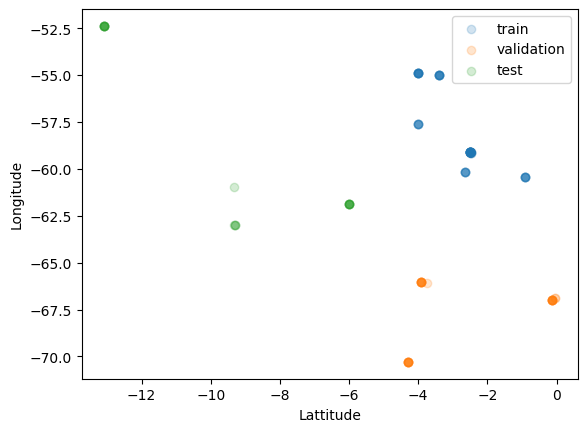

In [12]:
# Optional (plot splits)
import matplotlib
import matplotlib.pyplot as plt

plt.scatter(train_data["lat"], train_data["long"], label="train", alpha=0.2)
plt.scatter(validation_data["lat"], validation_data["long"], label="validation", alpha=0.2)
plt.scatter(test_data["lat"], test_data["long"], label="test", alpha=0.2)
plt.xlabel('Lattitude')
plt.ylabel('Longitude')
plt.legend()
plt.show()

In [13]:
train_data.to_csv(raster.get_sample_db_path(OUTPUT_TRAIN_CSV_PATH))
validation_data.to_csv(raster.get_sample_db_path(OUTPUT_VALIDATION_CSV_PATH))
test_data.to_csv(raster.get_sample_db_path(OUTPUT_TEST_CSV_PATH))

In [14]:
train_data['d18O_cel_mean'].unique()

array([26.748   , 26.862   , 26.29    , 26.884   , 26.536   , 26.01    ,
       27.206   , 26.762   , 25.706   , 26.738   , 24.376   , 26.962   ,
       26.062   , 25.09    , 26.398   , 26.492   , 27.231195, 27.22    ,
       24.3     , 26.601685, 26.566495, 27.90176 , 26.65447 , 27.85875 ,
       27.637835, 23.648   , 25.43    , 25.88    , 23.828   , 24.794   ,
       24.89    , 25.106   , 25.654   , 26.202   , 27.35    , 25.796   ,
       26.532   , 23.442   , 22.85    , 23.932   , 25.37    , 25.266   ,
       26.628   , 24.782   , 24.81    , 24.662   , 23.682   , 27.714   ,
       26.82    , 26.686   , 26.144   , 26.134   , 25.576   , 26.52    ,
       25.33    , 25.882   , 24.792   , 26.22    , 25.772   , 25.95    ,
       25.6725  , 25.9     , 25.018   , 25.16    , 26.542   , 27.096   ,
       26.13    , 26.984   ])